<a id="1"></a>
<h1 style="
    background-image: url('https://i.postimg.cc/76kNRZtb/we.webp');
    background-size: cover;
    background-repeat: no-repeat;
    font-family: 'Arial', sans-serif;
    font-size: 24px;
    color: white;
    text-align: center;
    border-radius: 15px 50px;
    padding: 20px 40px;
    margin: 20px 0;
    box-shadow: 0px 4px 8px rgba(0, 0, 0, 0.5);">
    <b>Normalization</b>
</h1>

**Importing Libraries**

In [8]:
# Importing installed libraries and Python packages
try:
  import pandas as pd                                                     # For data manipulation
  import pysradb                                                          # For accessing and managing SRA data
  import subprocess                                                       # For executing system commands from Python
  import os                                                               # For file management
  from tqdm import tqdm                                                   # For creating progress bars
  import numpy as np                                                      # For numerical computations
  import scipy.stats as stats                                             # For statistical analysis
  import numpy as np                                                      # For numerical computations
  import matplotlib.pyplot as plt                                         # For plotting
  import seaborn as sns                                                   # For creating advanced visualizations
  import pysam                                                            # For working with BAM and SAM files
  import gffutils                                                         # For handling GFF files
  import pydeseq2                                                         # For differential gene expression analysis
  from sklearn.preprocessing import StandardScaler                        # For preprocessing the data
  from pydeseq2.dds import DeseqDataSet                                   # For Read counts modeling with the DeseqDataSet class
  from pydeseq2.ds import DeseqStats                                      # Statistical analysis with the DeseqStats class
  from pydeseq2.default_inference import DefaultInference                  
  from IPython.display import IFrame                                      # For Reading the web frame
  import scanpy as sc
  import plotly.express as px  
  import warnings                                                         # For hiding the warning text
  from sklearn.exceptions import ConvergenceWarning
  warnings.filterwarnings("ignore", category=ConvergenceWarning)
  print("All Python packages imported successfully.")
except ImportError as e:
  print(f"Import failed: {e}")                                            # Print error message if import fails

/home/mahendra/anaconda3/lib/python3.12/site-packages/pysradb/utils.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


All Python packages imported successfully.


**Step 1:** Loading quantified and cleaned counts matrix

In [10]:
counts_df = pd.read_csv("cleaned_counts_matrix.csv", index_col=0).T
metadata = pd.read_csv("cleaned_metadata.csv", index_col=0)
print("\nCounts DataFrame:")
counts_df.head(10)


Counts DataFrame:


Geneid     A1BG  A1BG-AS1  A1CF   A2M  A2M-AS1  A2ML1  A2ML1-AS1  A2MP1  \
SRR085474    48        11     0  1173       21     55          0      1   
SRR085473    34         3     0   438        1     47          5      0   
SRR085726    68        17     1   439        3     28          0      3   
SRR085471    53        16     1  1419       15     50          0      0   
SRR087416    44        13     0   475        8     31          2      3   
SRR085725    40        10     0  1068       19     21          0      1   

Geneid     A3GALT2  A4GALT  ...  ZWINT  ZXDA  ZXDB  ZXDC  ZYG11A  ZYG11B  ZYX  \
SRR085474        0      42  ...     22    34   129   285       1     773    0   
SRR085473        1     120  ...      5     2    14    80       1      89    0   
SRR085726        1      94  ...     17    14    67   212       0     316    0   
SRR085471        1      32  ...     36    39   139   271       0     726    0   
SRR087416        2      59  ...     14    14    79   155       0     341    0   
SRR085725        0      46  ...     10    56   157   286       3     916    0   

Geneid     ZYX_1  ZZEF1  ZZZ3  
SRR085474      0    530   222  
SRR085473      0    149    78  
SRR085726      0    420   249  
SRR085471      0    539   210  
SRR087416      0    313   244  
SRR085725      0    629   243  

[6 rows x 50037 columns]

In [11]:
print("\nSimplified Metadata DataFrame:")
metadata.head(6)


Simplified Metadata DataFrame:


Sample condition
SRR_ID                                               
SRR085474        Normal brain, frontal lobe    Normal
SRR085473  Alzheimer's brain, temporal lobe        AD
SRR085726   Alzheimer's brain, frontal lobe        AD
SRR085471       Normal brain, temporal lobe    Normal
SRR087416           Alzheimer's whole brain        AD
SRR085725                Normal whole brain    Normal

In [12]:
# Ensure counts_df and metadata are aligned
common_samples = counts_df.index.intersection(metadata.index)
counts_df = counts_df.loc[common_samples]
metadata = metadata.loc[common_samples]

In [13]:
print(f"Counts DataFrame Shape: {counts_df.shape}")
print(f"Metadata DataFrame Shape: {metadata.shape}")

Counts DataFrame Shape: (6, 50037)
Metadata DataFrame Shape: (6, 2)


**Step 2:** Filter lowly expressed genes

In [15]:
# Remove genes with sum of counts across all samples < 10
genes_to_keep = counts_df.columns[counts_df.sum(axis=0) >= 10]
counts_df = counts_df[genes_to_keep]

**Step 3:** DESeq2 Normalized Dataset Creation

In [17]:
inference = DefaultInference(n_cpus=8) # Specifying the number of CPU cores (n_cpus) to use for parallelized computations.
dds = DeseqDataSet(                    # Creates a DESeq2 dataset object.
    counts=counts_df,                  # A DataFrame (counts_df) containing raw read counts for each gene across samples.
    metadata=metadata,                 # Metadata DataFrame that includes sample annotations (e.g., condition).
    design_factors=["condition"],      # Design matrix based on condition.
    refit_cooks=True,                  # A flag to refit the data in cases where Cook's distance indicates outlier
    inference=inference,               # The computational engine to use for performing the differential expression analysis.
)
dds.deseq2()                           # DESeq2 workflow.

Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 4.42 seconds.

Fitting dispersion trend curve...
... done in 0.36 seconds.

Fitting MAP dispersions...
... done in 4.97 seconds.

Fitting LFCs...
... done in 2.71 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.



### Executes the pyDESeq2 workflow, which includes:
- Normalization of raw counts (e.g., by size factors).
- Fitting generalized linear models (GLMs) for each gene to test for differential expression.
- Estimation of fold changes, p-values, and adjusted p-values (false discovery rate, FDR).
- After running this, the dds object contains all the results needed for downstream analysis.

<a id="1"></a>
<h1 style="
    background-image: url('https://i.postimg.cc/76kNRZtb/we.webp');
    background-size: cover;
    background-repeat: no-repeat;
    font-family: 'Arial', sans-serif;
    font-size: 24px;
    color: white;
    text-align: center;
    border-radius: 15px 50px;
    padding: 20px 40px;
    margin: 20px 0;
    box-shadow: 0px 4px 8px rgba(0, 0, 0, 0.5);">
    <b>Visualization</b>
</h1>

**Step 4:** Principal Component Analysis (PCA) plot: which visualizes the relationships between samples based on gene expression data. Here's an interpretation:

**Separation Between Groups:** 
- The plot shows how well the two conditions (Normal vs. AD) are separated based on their PCA values.
- If the two groups (colors) are well-separated along PC1 or PC2, it suggests a strong difference in gene expression patterns between the conditions.

**Spread Within Groups:**
- The spread of points within each group reflects variability in the gene expression profiles of the samples in that group.
- If points are tightly clustered, it suggests low variability within that group. In this plot, there seems to be some variability within both groups.

**Dominance of PC1:**

- Since PC1 explains 81.56% of the variance, most of the differences between samples are captured along this dimension based on experimental factor being studied (e.g., Normal vs. AD).

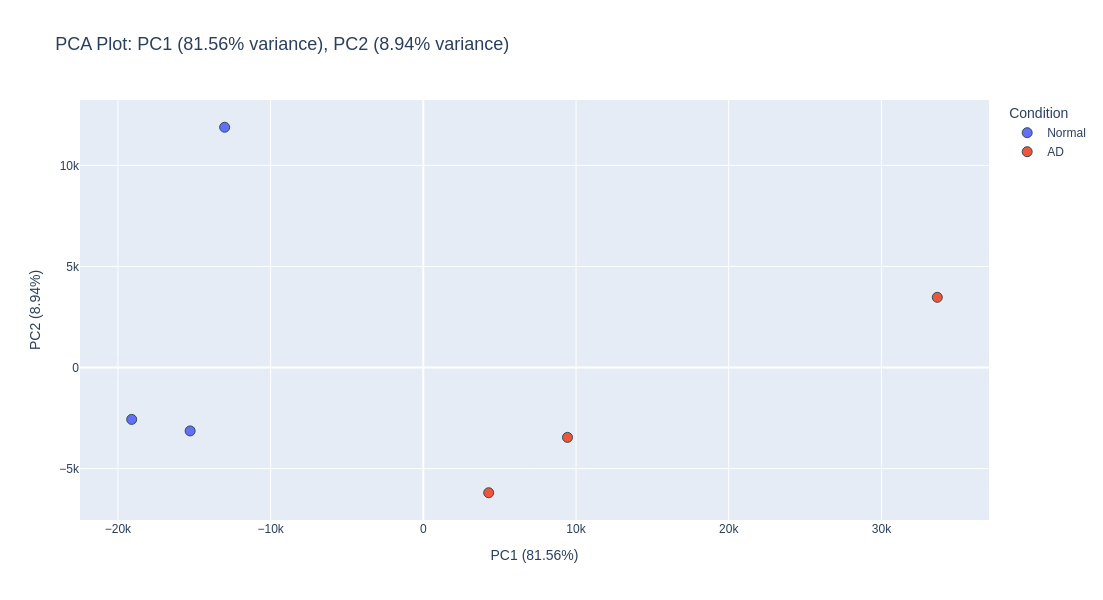

In [20]:
adata = sc.AnnData(dds)                                                        # Create an AnnData object from normalized_counts
adata.obs = metadata                                                           # Attach metadata to AnnData
sc.tl.pca(adata)                                                               # Perform PCA with scanpy


# Extract the variance explained for PC1 and PC2
explained_variance = adata.uns['pca']['variance_ratio']
pc1_variance = explained_variance[0] * 100                                     # Convert to percentage
pc2_variance = explained_variance[1] * 100

# Create a DataFrame for PCA results
pca_df = pd.DataFrame(
    adata.obsm['X_pca'][:, :2],                                                # Extract first two principal components
    columns=['PC1', 'PC2'],
    index=adata.obs_names
)
pca_df = pca_df.join(metadata)                                                 # Attach metadata

# Plot PCA using Plotly
fig = px.scatter(
    pca_df,
    x='PC1',
    y='PC2',
    color='condition',                                                         # Replace 'condition' with the relevant metadata column
    title=f"PCA Plot: PC1 ({pc1_variance:.2f}% variance), PC2 ({pc2_variance:.2f}% variance)",
    labels={'PC1': f"PC1 ({pc1_variance:.2f}%)", 'PC2': f"PC2 ({pc2_variance:.2f}%)"},
    hover_data=pca_df.columns,
    template='plotly'
)

# Customize the figure layout
fig.update_traces(marker=dict(size=10, line=dict(width=1, color='DarkSlateGrey')))
fig.update_layout(
    title_font_size=18,
    legend_title_text='Condition',
    xaxis=dict(title=f"PC1 ({pc1_variance:.2f}%)"),
    yaxis=dict(title=f"PC2 ({pc2_variance:.2f}%)"),
    width=800,
    height=600,
)
fig.show()                                                                       # Display the Plotly figure

**Step 5:** Create a DeseqStats object

In [22]:
stat_res = DeseqStats(dds, inference=inference)
stat_res.summary()                                                       # Summarize results
res = stat_res.results_df                                                # Extract results into a DataFrame
res["-log10(pvalue)"] = -np.log10(res["pvalue"])                         # Add additional columns for visualization
res["Significant"] = res["padj"] < 0.05
res.to_csv('ge_results.csv', index=True)                                 # Save results to a CSV file
print("\nDifferential expression results saved to 'ge_results.csv'")     # Display a summary of results
res.head(16)

Running Wald tests...
... done in 1.47 seconds.



Log2 fold change & Wald test p-value: condition Normal vs AD
            baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
Geneid                                                                      
A1BG       48.543703       -0.722360  0.352585 -2.048757  0.040486  0.134800
A1BG-AS1   10.631898       -0.373272  0.610283 -0.611637  0.540778  0.706626
A2M       780.120409        0.609157  0.356555  1.708453  0.087552  0.224356
A2M-AS1     9.239126        1.625050  0.727348  2.234211  0.025469  0.100565
A2ML1      43.069749       -0.704473  0.593920 -1.186141  0.235566  0.424051
...              ...             ...       ...       ...       ...       ...
ZXDB       83.428304        0.897868  0.355518  2.525519  0.011553  0.060701
ZXDC      196.561299        0.300882  0.225840  1.332277  0.182769  0.362159
ZYG11B    449.952161        1.163592  0.270407  4.303114  0.000017  0.000671
ZZEF1     391.109920        0.348021  0.222080  1.567097  0.117092  0.272768
ZZZ3      194.7

baseMean  log2FoldChange     lfcSE      stat    pvalue      padj  \
Geneid                                                                          
A1BG        48.543703       -0.722360  0.352585 -2.048757  0.040486  0.134800   
A1BG-AS1    10.631898       -0.373272  0.610283 -0.611637  0.540778  0.706626   
A2M        780.120409        0.609157  0.356555  1.708453  0.087552  0.224356   
A2M-AS1      9.239126        1.625050  0.727348  2.234211  0.025469  0.100565   
A2ML1       43.069749       -0.704473  0.593920 -1.186141  0.235566  0.424051   
A4GALT      84.574311       -2.136520  0.541885 -3.942752  0.000081  0.002206   
AACS       421.520470        0.177657  0.288088  0.616675  0.537449  0.703942   
AACSP1       2.566956        1.371315  1.269808  1.079939  0.280169       NaN   
AADAT       55.318075        0.078328  0.379820  0.206225  0.836615  0.906973   
AAGAB      240.356772        0.386021  0.254826  1.514841  0.129813  0.291166   
AAK1      1143.655506        0.427816  0.258173  1.657093  0.097501  0.241921   
AAMDC       59.018806       -0.516572  0.421867 -1.224489  0.220768  0.407884   
AAMP       502.671138       -0.097609  0.199695 -0.488789  0.624991  0.769296   
AANAT        7.603681       -1.431000  0.702915 -2.035807  0.041770  0.137575   
AAR2       154.885474       -0.115716  0.230572 -0.501866  0.615762  0.762167   
AARD         4.967290        1.500012  1.005885  1.491236  0.135899       NaN   

          -log10(pvalue)  Significant  
Geneid                                 
A1BG            1.392696        False  
A1BG-AS1        0.266981        False  
A2M             1.057732        False  
A2M-AS1         1.593985        False  
A2ML1           0.627887        False  
A4GALT          4.093924         True  
AACS            0.269663        False  
AACSP1          0.552579        False  
AADAT           0.077474        False  
AAGAB           0.886683        False  
AAK1            1.010992        False  
AAMDC           0.656064        False  
AAMP            0.204126        False  
AANAT           1.379139        False  
AAR2            0.210587        False  
AARD            0.866782        False

In [23]:
# Save results
res.to_csv("differential_expression_results.csv")
print("Results saved to 'differential_expression_results.csv'")

Results saved to 'differential_expression_results.csv'


**Step 6:** Volcano Plot that visually represents the results of a differential gene expression analysis

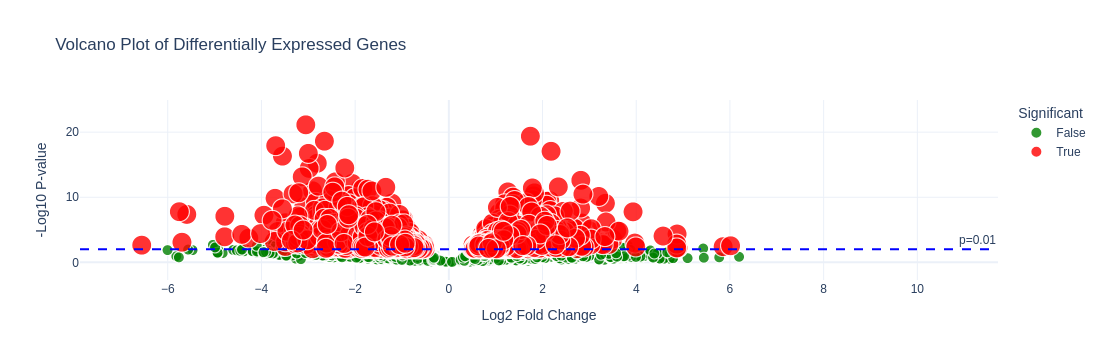

In [86]:
fig = px.scatter(
    res,
    x="log2FoldChange",
    y="-log10(pvalue)",
    color="Significant",
    color_discrete_map={True: "red", False: "green"},
    hover_name=res.index,  # Gene names (index)
    title="Volcano Plot of Differentially Expressed Genes",
    labels={"log2FoldChange": "Log2 Fold Change", "-log10(pvalue)": "-Log10 P-value"},
    template="plotly_white",
    size=np.where(res["Significant"], 10, 3),  # Larger size for significant genes
    opacity=0.8
)
fig.add_hline(y=-np.log10(0.01), line_dash="dash", line_color="blue", annotation_text="p=0.01")
fig.show()

**Upregulated Genes:** These are significant genes with positive log2 fold change (right side, red points).
They are more highly expressed in the condition of interest compared to the reference.

**Downregulated Genes:** These are significant genes with negative log2 fold change (left side, red points).
They are less expressed in the condition of interest compared to the reference.

**Central Region (Log2 Fold Change ≈ 0):** Genes in this region show little to no difference in expression between conditions.
Most of these are not statistically significant (green points).

**Significance Trends:** Genes farther from the center (either left or right) with higher -log10(p-value) are the most likely to be biologically meaningful, as they have both a large fold change and high statistical significance.


In [83]:
# Add upregulation and downregulation classification
res["Regulation"] = res.apply(
    lambda x: "Upregulated" if (x["log2FoldChange"] > 0 and x["Significant"])
    else "Downregulated" if (x["log2FoldChange"] < 0 and x["Significant"])
    else "Not Significant",
    axis=1
)

# Summarize counts as a DataFrame
summary_df = res["Regulation"].value_counts().reset_index()
summary_df.columns = ["Regulation", "Count"]
# Save both classified results and summary
res.to_csv("classified_genes.csv", index=True)
summary_df.to_csv("regulation_summary.csv", index=False)
# Display the summary DataFrame
print("\nOver all Summary:")
summary_df


Over all Summary:


Regulation  Count
0  Not Significant  17848
1    Downregulated   1441
2      Upregulated   1330

**Step 7:** Heatmap

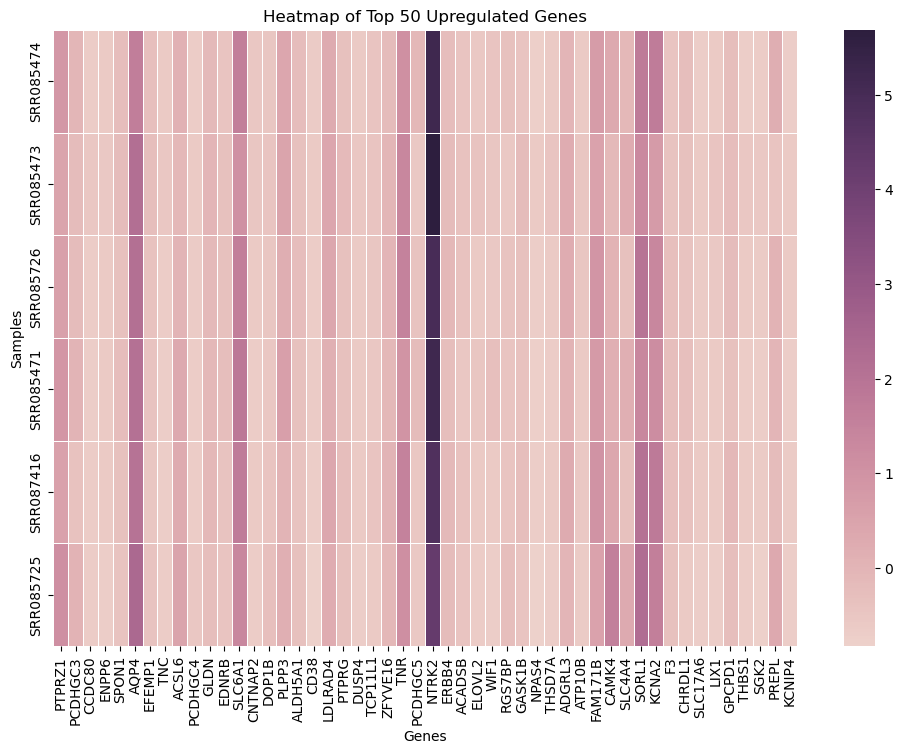

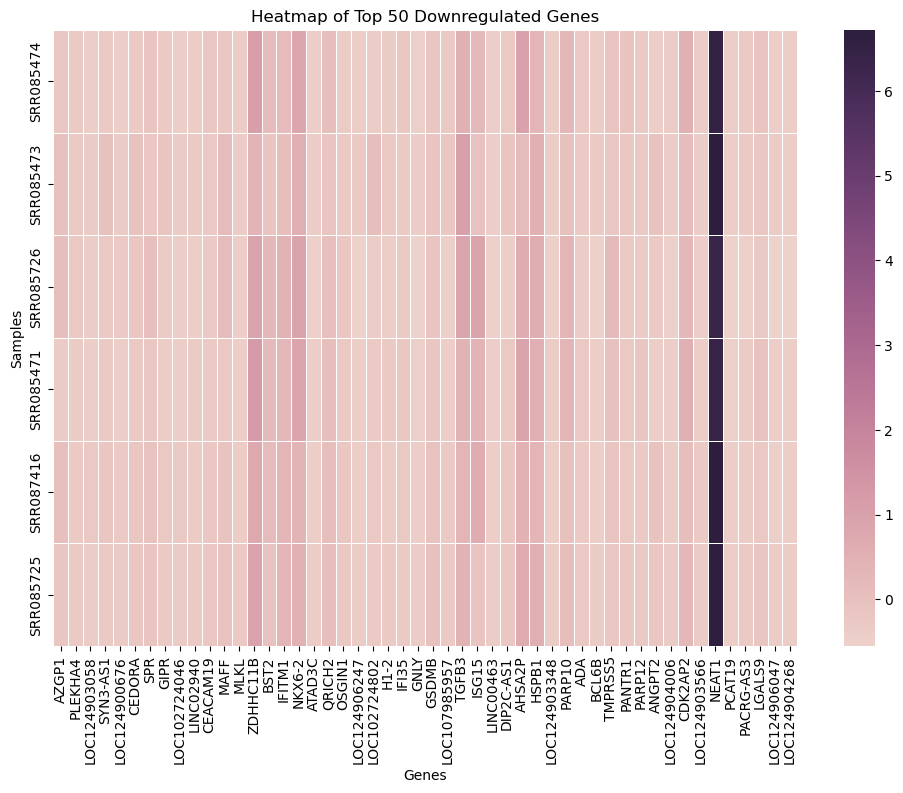

In [75]:
# Classify genes into upregulated and downregulated
upregulated_genes = res[(res["Significant"]) & (res["log2FoldChange"] > 0)].sort_values("padj").head(50).index
downregulated_genes = res[(res["Significant"]) & (res["log2FoldChange"] < 0)].sort_values("padj").head(50).index

# Subset counts for each category
upregulated_counts = counts_df[upregulated_genes]
downregulated_counts = counts_df[downregulated_genes]

# Function to standardize and plot heatmap
def plot_heatmap(counts, title):
    # Standardize counts
    scaler = StandardScaler()
    scaled_counts = scaler.fit_transform(counts.T)  # Transpose for scaling

    # Create DataFrame with scaled values
    scaled_df = pd.DataFrame(
        scaled_counts.T,  # Transpose back to match original orientation
        index=counts.index,  # Samples
        columns=counts.columns  # Genes
    )

    # Plot heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(scaled_df, cmap=sns.cubehelix_palette(as_cmap=True), xticklabels=True, yticklabels=True,linewidth=.4)
    plt.title(title)
    plt.xlabel("Genes")
    plt.ylabel("Samples")
    plt.show()

# Plot heatmaps
plot_heatmap(upregulated_counts, "Heatmap of Top 50 Upregulated Genes")
plot_heatmap(downregulated_counts, "Heatmap of Top 50 Downregulated Genes")

<a id="1"></a>
<h1 style="
    background-image: url('https://i.postimg.cc/76kNRZtb/we.webp');
    background-size: cover;
    background-repeat: no-repeat;
    font-family: 'Arial', sans-serif;
    font-size: 24px;
    color: white;
    text-align: center;
    border-radius: 15px 50px;
    padding: 20px 40px;
    margin: 20px 0;
    box-shadow: 0px 4px 8px rgba(0, 0, 0, 0.5);">
    <b>Result Interpretation</b>
</h1>

In [92]:
# Filter significant genes
significant_genes = res[(res["padj"] < 0.05) & (abs(res["log2FoldChange"]) > 1)]

# Subset upregulated and downregulated genes
upregulated_genes = significant_genes[significant_genes["log2FoldChange"] > 1]
downregulated_genes = significant_genes[significant_genes["log2FoldChange"] < -1]

# Create a summary DataFrame
summary_data = {
    "Category": ["Significant Genes", "Upregulated Genes", "Downregulated Genes"],
    "Count": [len(significant_genes), len(upregulated_genes), len(downregulated_genes)]
}
summary_df = pd.DataFrame(summary_data)

# Save the summary DataFrame
summary_df.to_csv("gene_summary.csv", index=False)

# Save the significant, upregulated, and downregulated genes separately
significant_genes.to_csv("significant_genes.csv", index=True)
upregulated_genes.to_csv("upregulated_genes.csv", index=True)
downregulated_genes.to_csv("downregulated_genes.csv", index=True)

# Display the summary DataFrame
print("\nUpregulated and Downregulated Genes:")
summary_df


Upregulated and Downregulated Genes:


Category  Count
0    Significant Genes   1752
1    Upregulated Genes    782
2  Downregulated Genes    970

### References
- [Jupyter Notebook](https://jupyter.org/)
- [Gooogl Colab](https://colab.google/)
- [python](https://www.python.org/)
- [SRA](https://www.ncbi.nlm.nih.gov/sra/SRX035760[accn])
- [SRA-TOOLS](https://github.com/ncbi/sra-tools/wiki)
- [FASTQC](https://www.bioinformatics.babraham.ac.uk/projects/fastqc/)
- [multiqc](https://seqera.io/multiqc/)
- [Qualimap](http://qualimap.conesalab.org/)
- [Picard](https://broadinstitute.github.io/picard/)
- [Cutadapt](https://cutadapt.readthedocs.io/en/stable/guide.html)
- [htseq](https://htseq.readthedocs.io/en/master/install.html)
- [bwa](https://bio-bwa.sourceforge.net/bwa.shtml)